# Convolutional Layers

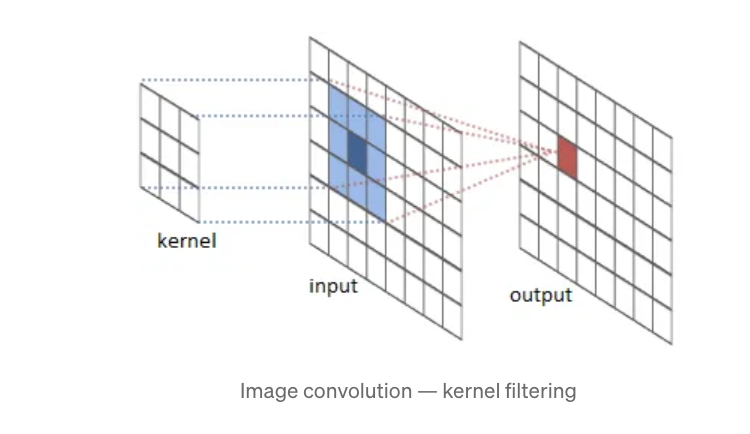

All the way to the left hand side is your Convolutional layer, the middle is the input image, and the right hand side has the output image. Note that this image assumes you've done padding so that the resulting output image is the same size as the input image. This is equivalent to passing `padding="same"` - where we instruct TensorFlow to add enough zeros to the edge of the input image so that when we run over it with our kernel, the aggregation results in an equal-sized output. 

If you had put `padding="valid"`, this would have instructed TensorFlow to not add any zeros, so the output image would have been smaller than the input image. This comes from the terminology that every pixel in the input image is coming from a "valid" point in the input receptive field (you're not creating imaginary zeros outside the original image just so the aggregation works).


We're going to go through some custom image manipulations with a very popular image to show the effects of many of the transformations we're using.

First, download the image:

In [1]:
image_url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"
!wget -O lena.png $image_url

--2023-07-14 17:38:01--  https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘lena.png’

lena.png            100%[===================>] 462.73K  2.28MB/s    in 0.2s    

2023-07-14 17:38:01 (2.28 MB/s) - ‘lena.png’ saved [473831/473831]



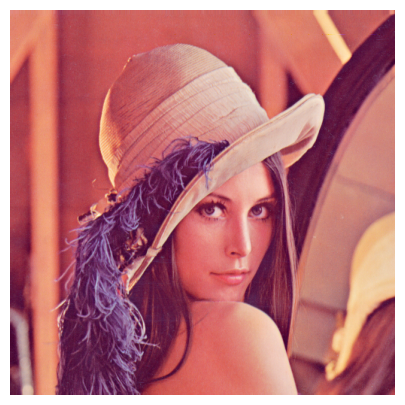

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

lena_image = cv2.imread('lena.png')
img = cv2.cvtColor(lena_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 5))
plt.axis("off")
plt.imshow(img)
plt.show()

Now we'll convert it to a greyscale image so that we can investigate the effects of performing various filters without having to deal with the 3 color channels:

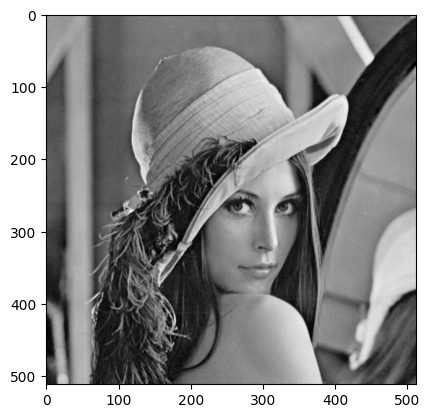

In [57]:
grey_lena = cv2.cvtColor(lena_image, cv2.COLOR_BGR2GRAY)
plt.imsave("grey_lena.png", grey_lena, cmap="gray")
grey_lena = cv2.imread("grey_lena.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(grey_lena, cmap="gray")
plt.show()

As you can see, we get a 2D numpy array from OpenCV, with pixel intensities between 0 and 255.

In [58]:
print(grey_lena.shape)
print(grey_lena)

(512, 512)
[[159 159 159 ... 168 151 119]
 [159 159 159 ... 168 151 119]
 [159 159 159 ... 168 151 119]
 ...
 [ 20  20  29 ...  91  87  84]
 [ 22  22  34 ...  91  93  96]
 [ 22  22  34 ...  91  93  96]]


What does it look like when we transpose the numpy array?

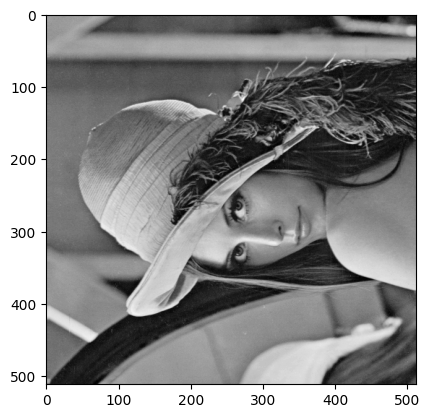

In [59]:
plt.imshow(grey_lena.T, cmap="gray")
plt.show()

So as we know from linear algebra, transposing a matrix is defined as taking the pixels in the top right of our image, and reflecting them over the diagonal line running from the top left of the image, to the bottom right of the image (notice how the brim of Lena's hat goes from (400, 100) to (100, 400)).


In general, the action of applying a filter to a matrix means to define another matrix (a kernel), and to aggregate the pointwise multiplication of the kernel with the image, while moving the kernel over each time you aggregate.

This is reminiscent of convolutions from mathematics, which are typically represented by integrals, and measure the "overlap" of two functions. In this case, we're measuring the "overlap" of our kernel with our image at each point on our image. Think of it as "applying" the kernel to the image at each point, and seeing what activation comes out. This is an extremely common task in signal processing.

Now, we can visualize the "effect" of some toy matrices on our original image. 

First off, we'll start with the identity transformation. If you have a background in linear algebra, you might think that this would be equivalent to the identity matrix:
$$
I = \begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

However, note that that matrix is only the identity matrix when you're performing matrix multiplication between two matrices. Here, we're performing a different kind of multiplication. So the identity matrix in this context would actually be:

$$
I = \begin{bmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0
\end{bmatrix}
$$

We'll use OpenCV's `filter2D` to apply our identity kernel across the original image, and define a helper function for testing out different kernels.

In [60]:
def plot_image_after_filter(title, image, filter):
    filtered_image = cv2.filter2D(image, -1, filter)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X=image, cmap="gray")
    ax[1].imshow(X=filtered_image, cmap="gray")
    plt.suptitle(title)
    plt.show()

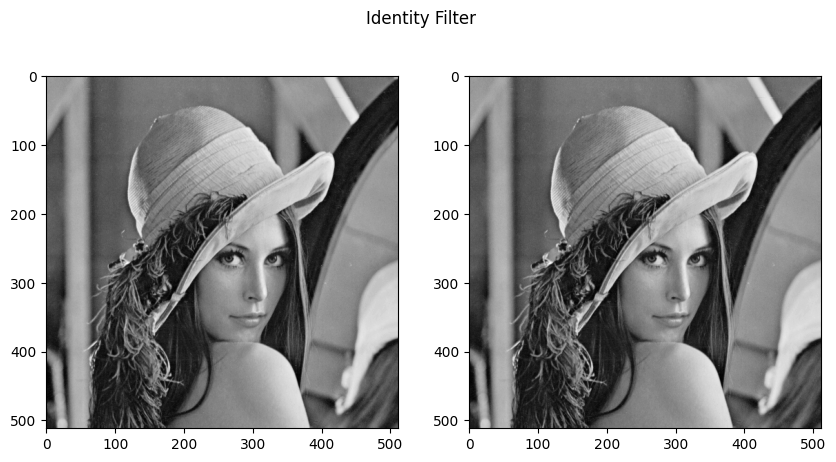

In [61]:
identity_kernel = np.array([[0,0,0], [0,1,0], [0, 0, 0]])
plot_image_after_filter("Identity Filter", grey_lena, identity_kernel)

Just out of curiosity, what would the identity matrix have looked like if we used that instead?

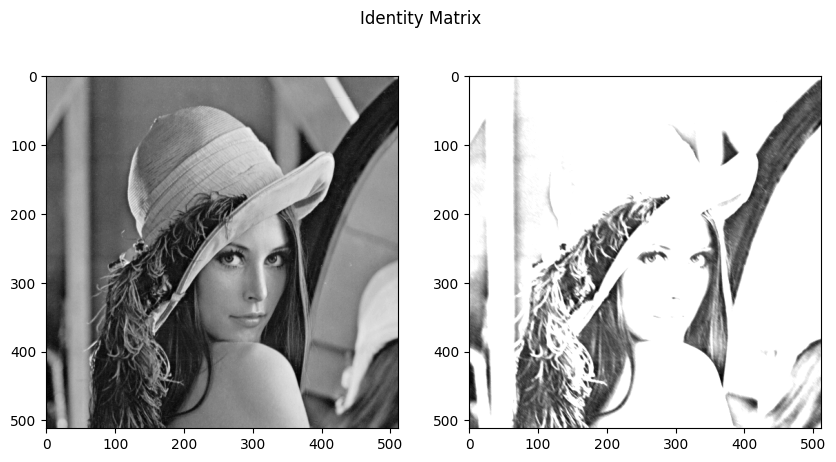

In [62]:
identity_matrix = np.array([[1,0,0], [0,1,0], [0, 0, 1]])
plot_image_after_filter("Identity Matrix", grey_lena, identity_matrix)

So the identity matrix from linear algebra looks like some sort of high contrast filter.

There are many different filters that have been posited out there as performing a particular task. Normally, in a CNN, you learn what these filters should be. But we can use some theory to posit hypothetical ones that do a good job.

Here is a common edge-detection filter:

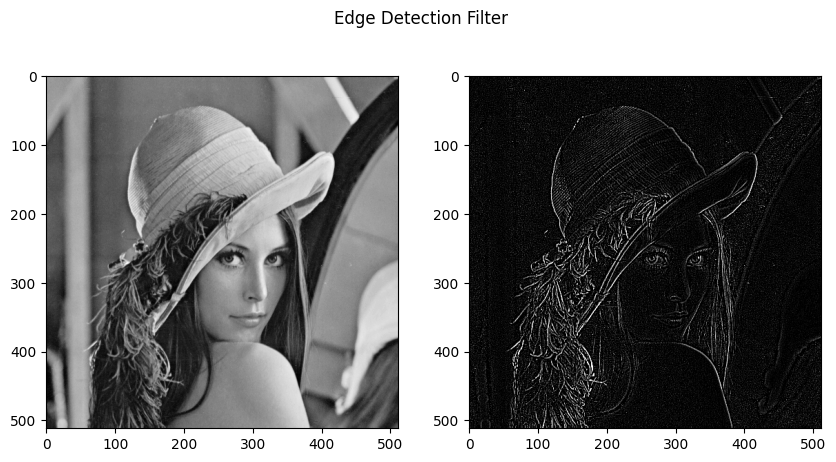

In [46]:
edge_detection_filter= np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])
plot_image_after_filter("Edge Detection Filter", grey_lena, edge_detection_filter)

Here is a horizontal edge detection filter:

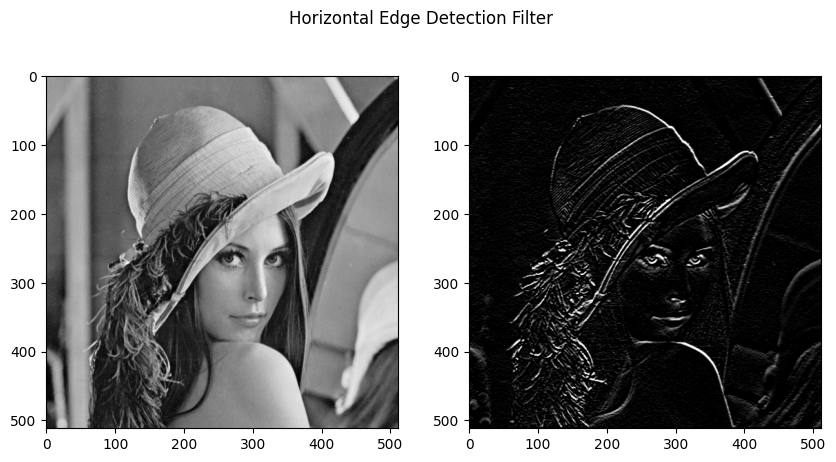

In [47]:
horizontal_edge_detection_filter= np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
plot_image_after_filter("Horizontal Edge Detection Filter", grey_lena, horizontal_edge_detection_filter)

Horizontal edge detection is used to detect sharp intensity changes within an image. This kernel will "activate" sharply when there are big differences in pixel intensities bewteen pixels that are vertically above or below one another, thus detecting the horizontal edge. Another way of thinking about this is that this kernel is an approximation of the derivative of the pixel intensity in the vertical direction.


The vertical edge detection filter would be the transpose of the horizontal one:

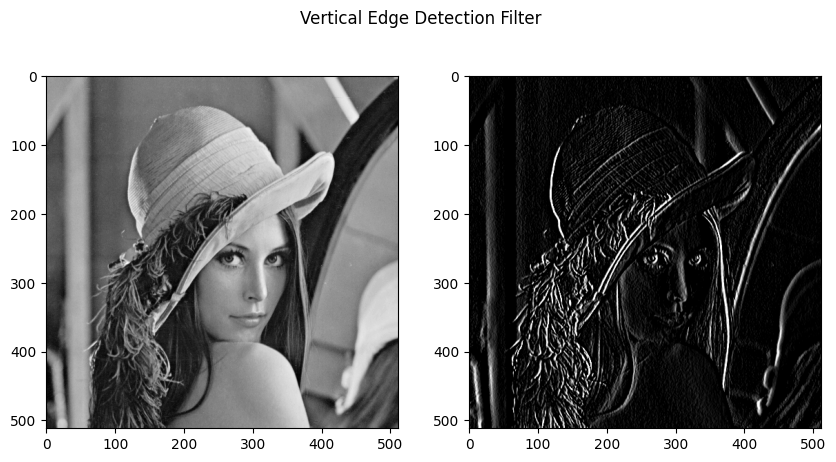

In [49]:
vertical_edge_detection_filter = horizontal_edge_detection_filter.T
plot_image_after_filter("Vertical Edge Detection Filter", grey_lena, vertical_edge_detection_filter)

## Convolutional Layers in TensorFlow

A **convolution** is a mathematical operation that slides one function over another and measures the integral of their pointwise multiplication.

Convolutional layers use cross-correlations, which are very similar to convolutions.

The benefit of using convolutional neural networks over fully connected layers is that successive convolutional neural networks are only connected to units in their local receptive fields, whereas in fully connected layers, every single pixel in a given layer is connected to every other pixel in a subsequent layer.

Note that convolutional neural networks are very RAM hungry. This is true especially during training because the reverse pass of backpropagation requires all of the values you computed during the forward pass.

In [51]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

In [54]:
images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1./255)(images)
print(images.shape)

Metal device set to: Apple M2 Max

systemMemory: 96.00 GB
maxCacheSize: 36.00 GB

(2, 70, 120, 3)


2023-07-14 18:48:53.404781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-14 18:48:53.404800: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The dimensions are explained as follows:
* 2 - there are two sample images in this dataset
* 70, 120 - each image is 70, 120 pixels (since we specified that in `CenterCrop`)
* 3 - there are 3 color channels

Now we can create a 2D convolutional layer and feed these images to it:

In [4]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)
print(fmaps.shape)

(2, 64, 114, 32)


These are 2 Dimensional convolutional neural networks, since we're dealing with 2 Dimensional images. However, these Conv2D layers take in tensors that are 4 dimensional. This is because we need to have the first dimension for batch size, and the last dimension for the channel. 

The dimensions in this new tensor are explained as follows:

* 2 - 2 samples
* 64, 114 - both our width and height of images decreased by 6 pixels because we're using a kernel size of 7. The way to think about this is that, you started with an image with 70 pixels in one dimension. You can only slide a kernel of size 7 across 70 pixels 64 times (you lose 6 pixels), if you don't add enough zeros to either end of the image to make it back. Think about sliding a kernel of size 3 across an image that's 5 pixels wide. You can only do this 3 times. The general formula is (number of pixels) - (kernel size) + 1. 70-7+1=64, and 5-3+1=3.
* 32 - because we had 32 filters, so we imagine having 32 output feature maps instead of our color channels

We can get back our weights and biases like this:

In [5]:
kernels, biases = conv_layer.get_weights()
print(kernels.shape)
print(biases.shape)

(7, 7, 3, 32)
(32,)


The shape of `kernels` is:
* 7 - the kernel height
* 7 - the kernel width (it's a square kernel)
* 3 - input_channels (3 colors)
* 32 - output channels (we set 32 filters)

## Pooling Layers

Pooling layers are the second common building block for CNNs.

The goal of a pooling layer is to **subsample** the input image in order to reduce the computational load, memory usage and the number of parameters.

Pooling layers don't have any trainable parameters; they just aggregate the inputs from the previous layer using an aggregation function like the max or mean. **Max** pooling layers are the most common. 

The only parameter you typically pass to pooling layers are the `pool_size`, which is the length of one side of the kernel. 

To implement these in TensorFlow, that looks like:

In [52]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

Sometimes you might see this global average pooling layer, which computes the average over the entire feature map (all of the pixels in the input).

There is one of these layers built into Keras, but it's just equivalent to a really simple `Lambda` layer implementation:

In [55]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

global_avg_pool_lambda = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2])
)
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338803, 0.5971821 , 0.58250374],
       [0.76307476, 0.26010975, 0.10848834]], dtype=float32)>

In this case, we got the average intensity of the pixels for each of the images, for each of the channels; so we have 6 values here, since we had 2 images, and 3 values for the channels on each image.

## Pooling Layers from Scratch

To implement pooling layers, we need to write logic to move an iterator across all possible pools of our input image, and perform an aggregation:

In [56]:
def generate_pools(img: np.array, pool_size: int, stride: int) -> np.array:
    """
    We assume the image is a square, and the pool size is a square

    We're just generating numpy sub arrays here, and appending them to a list
    of arrays.
    """
    pools = []
    for i in np.arange(img.shape[0], step=stride):
        for j in np.arange(img.shape[0], step=stride):
            pool = img[i:i+pool_size, j:j+pool_size]

            if pool.shape == (pool_size, pool_size):
                pools.append(pool)

    return np.array(pools)


def compute_max_pooling(pools: np.array) -> np.array:
    """
    For each of the sub arrays we generated (the pools), compute the 
    aggregation.
    """
    number_of_pools = pools.shape[0]

    # square root of the number of pools; everything's a square
    output_shape = (int(np.sqrt(number_of_pools)), int(np.sqrt(number_of_pools)))

    pooled_max_values = []

    for pool in pools:
        pooled_max_values.append(np.max(pool))

    return np.array(pooled_max_values).reshape(output_shape)

And we'll show an example of how this is used:

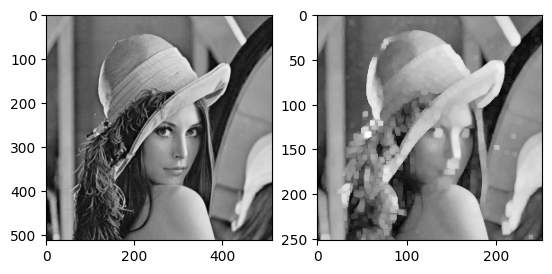

In [69]:
grey_lena_pools = generate_pools(grey_lena, pool_size=10, stride=2)
lena_max_pooling = compute_max_pooling(grey_lena_pools)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(grey_lena, cmap="gray")
ax[1].imshow(lena_max_pooling, cmap="gray")
plt.show()